In [9]:
import os
from collections import defaultdict

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'

from adjustText import adjust_text

from Bio import SeqIO

from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [10]:
datadir = '../data/dnaPipeTE-out'
dnapipete_data = {sp: f'{datadir}/{sp}/Counts.txt' for sp in os.listdir(datadir)}

In [11]:
def read_counts(countfile):
    count_df = pd.read_csv(countfile, sep='\t', header=None, names=['teclass', 'readcount'])
    return count_df

def count_finz_znf(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

def count_finz_exons(species):
    count = 0
    with open(f'../data/blast-out/{species}_finz_locs.out') as infile:
        for line in infile:
            count += 1
    return count

def count_znf_hits(species):
    count = 0
    with open(f'../data/blast-out/{species}_znf_locs.out') as infile:
        for line in infile:
            count += 1
    return count

def age_proportions():
    divdict = defaultdict(list)
    for species in dnapipete_data.keys():
        landscape_df = pd.read_csv(f'../data/dnaPipeTE-out/{species}/reads_landscape', 
                                   sep=r'\s+', 
                                   header=None, 
                                   names=['identity', 'tename', 'tefam', 'teclass'])
        landscape_df['divergence'] = 100 - landscape_df.identity
        step = 5
        total = landscape_df.tename.count()
        divdict['species'].append(species)
        for i in range(0, int(np.ceil(max(landscape_df.divergence)))+1+step, step):
            divdict[f'lt_{i}'].append(landscape_df.loc[landscape_df.divergence <= i, 'tename'].count()/total)
            divdict[f'gt_{i}'].append(landscape_df.loc[landscape_df.divergence > i, 'tename'].count()/total)
    return pd.DataFrame.from_dict(divdict)
    


In [44]:
count_dfs = []
for sp, val in dnapipete_data.items():
    count_df = read_counts(val)
    count_df['species'] = sp
    count_df['finz_znf'] = count_finz_znf(sp)
    count_df['finz_exons'] = count_finz_exons(sp)
    count_df['znf_hits'] = count_znf_hits(sp)
    count_dfs.append(count_df)

count_df = pd.concat(count_dfs)
count_df = count_df.pivot_table(index=['species', 'finz_exons', 'finz_znf', 'znf_hits'], 
                                columns='teclass', 
                                values='readcount') \
    .sort_values('finz_znf') \
    .reset_index()
count_df['Unknown'] = count_df.na + count_df.others
count_df = count_df.drop(['Others', 'Tandem_repeats', 'na', 'others', 'rRNA', 'MITE', 'Simple_repeat'], axis=1)
count_df['interspersed'] = count_df.DNA + count_df.LTR + count_df.LINE + count_df.SINE + count_df.Helitron + count_df.Unknown
    
for teclass in ['DNA', 'Helitron', 'LINE', 'LTR', 'SINE', 'Low_Complexity', 'Satellite', 'Unknown', 'interspersed', 'Total']:
    count_df[teclass] = count_df[teclass]/count_df['Total']*100

with open('../data/species_genomes.txt') as infile:
    hiqual = [line.split()[0] for line in infile]
count_df = count_df.loc[count_df.species.isin(hiqual)]
print(count_df)
count_df2 = count_df.loc[~count_df.species.str.startswith('Chanos')]
count_df2 = count_df2.loc[~count_df.species.str.startswith('Triplophysa')]

teclass                          species  finz_exons  finz_znf  znf_hits  \
0                   Triplophysa_tibetana           0         0      7459   
1                    Triplophysa_dalaica           0         0      6336   
2                          Chanos_chanos           0         0      4536   
3                 Triplophysa_siluroides           1         0      6513   
4                     Danionella_dracula           3         4      8474   
5                 Danionella_translucida           5         9      6400   
6            Hypophthalmichthys_molitrix          99        16     14368   
7                          Danio_choprai          92        64      6583   
8                    Danio_jaintianensis         111        93      7129   
9                          Danio_tinwini         150        96      8636   
10                    Leuciscus_waleckii         196       106     14638   
11                   Puntigrus_tetrazona         204       135      8042   
12          

In [51]:
pic_df = pd.read_csv('../data/finz_pics.txt', sep='\t')
print(pic_df)

    pic.finz_exons  pic.interspersed  pic.finz_znf    pic.DNA    pic.LTR  \
0       727.393189         11.244224    301.450068   2.023063   3.338188   
1       174.494892         -0.089357    -51.630794 -12.479604   2.282441   
2      -871.460351        -27.278606   -674.313405 -31.468188  -1.356978   
3       812.331141         -2.911227     86.214803  12.507308  -4.520827   
4       -59.818639          5.652111    -56.393705 -15.964740   1.738311   
5       706.224576         -6.402454    -97.152587   5.032370  -5.410855   
6       218.860286         14.212478     53.579648   7.393964   5.262506   
7      -499.690443        -14.914267     86.401539  -6.987434  -4.673864   
8       727.216630          1.803679    -68.605342   3.910267  -3.080485   
9      -860.267516        -12.997257     79.654400   5.717046 -11.596340   
10      376.128362         93.348838    137.110832  57.942662   5.907019   
11     -187.983131         53.925533   -258.016062  -4.188628  12.393853   
12     1475.

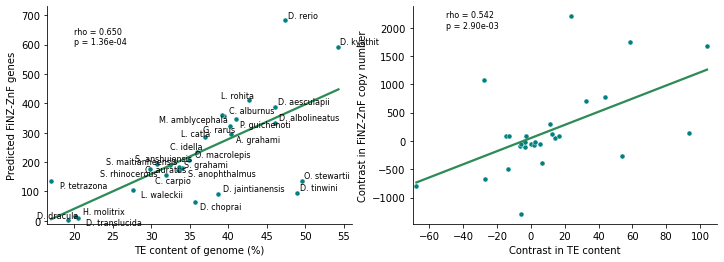

In [75]:
column = 'interspersed'
column2 = 'finz_znf'
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

sns.regplot(data=count_df2, 
            x=column, 
            y=column2,
            scatter=False,
            ci=None,
            color='seagreen',
            ax=ax[0])

sns.scatterplot(data=count_df2, 
                x=column, 
                y=column2,
                color='teal',
                s=25,
                ax=ax[0])

ax[0].set_xlim(16.5, 56)
ax[0].set_ylim(-10, 730)
# ax[0].get_legend().remove()
ax[0].set_xlabel('TE content of genome (%)')
ax[0].set_ylabel('Predicted FiNZ-ZnF genes')

labels = []
for row in count_df2.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax[0].text(row[1][column], row[1][column2], 
                             label, 
                             fontsize=8, 
                             va='center', 
                             ha='center'))
adjust_text(labels)

pval = stats.spearmanr(count_df2[column], 
                       count_df2[column2])
ax[0].text(x=20, 
        y=600, 
        s=f'rho = {pval[0]:.3f}\np = {pval[1]:.2e}',
        fontsize=8)

sns.regplot(data=pic_df, 
            x=f'pic.{column}', 
            y='pic.finz_znf',
            scatter=False,
            ci=None,
            color='seagreen',
            ax=ax[1])

sns.scatterplot(data=pic_df, 
                x=f'pic.{column}', 
                y='pic.finz_znf',
                color='teal',
                s=25,
                ax=ax[1])


ax[1].set_xlim(-70, 110)
ax[1].set_xlabel('Contrast in TE content')
ax[1].set_ylabel('Contrast in FiNZ-ZnF copy number')

picpval = stats.spearmanr(pic_df[f'pic.{column}'], 
                       pic_df['pic.finz_znf'])

ax[1].text(x=-50, 
           y=2000, 
           s=f'rho = {picpval[0]:.3f}\np = {picpval[1]:.2e}',
           fontsize=8)

sns.despine()
plt.show()
fig.savefig('../figs/finz_znf_corr.pdf', bbox_inches='tight', dpi=300)

A possible explanation for some of the noise in the correlation is genome assembly quality. Since the finz-znfs are normally present on specific, highly repetitive chromosomes, it is possible that low numbers of predicted genes could be due to collapsing or fragmentation of these regions. To test this, we will look at the correlation between N50 and finz count.

In [48]:
def calc_N50(genomefile):
    contiglens = []
    for record in SeqIO.parse(genomefile, 'fasta'):
        contiglens.append(len(record.seq))
    contiglens = sorted(contiglens, reverse=True)
    gsize = sum(contiglens)
    i, currentsize = 0, 0
    while currentsize <= gsize*0.5:
        currentsize += contiglens[i]
        i += 1
    return contiglens[i]

with open('../data/species_genomes.txt') as infile:
    genomes = {line.split()[0]: f'/Users/jonwells/Genomes/Cypriniformes/{line.split()[1]}' for line in infile}
genomes.pop('Chanos_chanos')


n50s = []
for species, genomefile in genomes.items():
    n50s.append((species, calc_N50(genomefile)))
n50_df = pd.DataFrame(n50s, columns=['species', 'N50'])
# n50_df = n50_df.merge(count_df, on='species')
print(n50_df.head())

                        species      N50
0               Cyprinus_carpio  7653411
1       Ctenopharyngodon_idella  6014843
2  Sinocyclocheilus_anshuiensis  1282074
3  Sinocyclocheilus_rhinocerous   945578
4      Sinocyclocheilus_grahami  1156011


In [49]:
n50_df = n50_df[['species', 'N50']]
n50_df = n50_df.merge(count_df, on='species')
print(n50_df)
n50_df.to_csv('../data/finz_te_counts.txt', sep='\t', header=True, index=False)

                            species       N50  finz_exons  finz_znf  znf_hits  \
0                   Cyprinus_carpio   7653411         523       157     19747   
1           Ctenopharyngodon_idella   6014843         341       235     10221   
2      Sinocyclocheilus_anshuiensis   1282074         400       195     11938   
3      Sinocyclocheilus_rhinocerous    945578         415       176      8832   
4          Sinocyclocheilus_grahami   1156011         550       174     11668   
5   Sinocyclocheilus_maitianheensis   1358641         390       189     11739   
6     Sinocyclocheilus_anophthalmus    309865         498       179     10597   
7                 Carassius_auratus  21934901         334       183     17005   
8          Oxygymnocypris_stewartii    256525         280       137     17186   
9               Anabarilius_grahami   4449300         547       294      9146   
10                     Labeo_rohita   1954488         715       410     14558   
11                      Labe

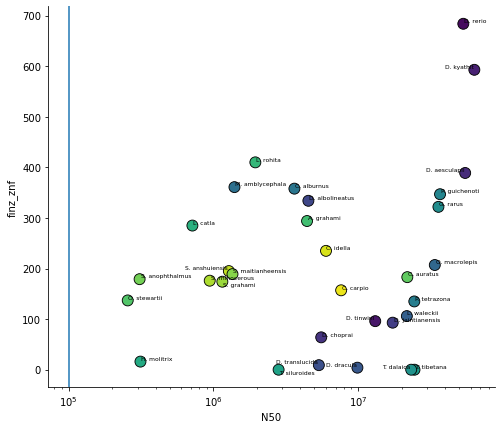

SpearmanrResult(correlation=0.15621563206541905, pvalue=0.3932212757310306)
SpearmanrResult(correlation=0.17375366568914952, pvalue=0.34157669639498467)


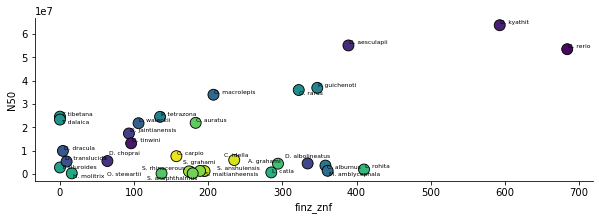

SpearmanrResult(correlation=0.15621563206541905, pvalue=0.3932212757310306)


In [66]:
min_N50 = 1e05
column = 'finz_znf'

fig, ax = plt.subplots(figsize=(8, 7)) 
sns.scatterplot(data=n50_df, 
                x='N50', 
                y=column,
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=120,
                ax=ax)
ax.axvline(x=min_N50)
ax.set_xscale('log')
ax.get_legend().remove()

labels = []
for row in n50_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1]['N50'], row[1][column], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()
print(stats.spearmanr(n50_df.loc[n50_df['N50'] >= min_N50].N50, n50_df.loc[n50_df['N50'] >= min_N50][column]))
print(stats.spearmanr(n50_df.loc[n50_df['N50'] >= min_N50].N50, n50_df.loc[n50_df['N50'] >= min_N50].interspersed))

fig, ax = plt.subplots(figsize=(10, 3)) 
sns.scatterplot(data=n50_df.loc[n50_df['N50'] >= min_N50], 
                y='N50', 
                x=column,
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=120,
                ax=ax)
ax.get_legend().remove()

labels = []
for row in n50_df.loc[n50_df['N50'] >= min_N50].iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1][column], row[1]['N50'], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()

print(stats.spearmanr(n50_df.loc[n50_df['N50'] >= min_N50].N50, n50_df.loc[n50_df['N50'] >= min_N50][column]))

In [23]:
print(n50_df.loc[n50_df['N50'] >= min_N50].reset_index().species)
n50_df.loc[n50_df['N50'] >= min_N50].reset_index()[['species']].to_csv('../data/n50_gt5e05.txt', header=False, index=False)

0                     Cyprinus_carpio
1             Ctenopharyngodon_idella
2        Sinocyclocheilus_anshuiensis
3        Sinocyclocheilus_rhinocerous
4            Sinocyclocheilus_grahami
5     Sinocyclocheilus_maitianheensis
6       Sinocyclocheilus_anophthalmus
7                   Carassius_auratus
8            Oxygymnocypris_stewartii
9                 Anabarilius_grahami
10                       Labeo_rohita
11                        Labeo_catla
12        Hypophthalmichthys_molitrix
13                  Gobiocypris_rarus
14         Paracanthobrama_guichenoti
15                Puntigrus_tetrazona
16                    Culter_alburnus
17           Megalobrama_amblycephala
18             Onychostoma_macrolepis
19                 Leuciscus_waleckii
20                 Danionella_dracula
21             Danionella_translucida
22                 Danio_albolineatus
23                Danio_jaintianensis
24                      Danio_choprai
25                   Danio_aesculapii
26          